# TensorFlow for ICT Applications

## Lab session 5: Advanced CNN

**Contents of this lab session:**
* Load image data in TF using tf.data and tf.image.
* Perform data augmentation on training images.
* Build a CNN architecture from scratch.
* Make training faster using tf.function.

### About the task

The data can be downloaded as **Dataset 1** from here:
https://github.com/SullyChen/driving-datasets

Direct Drive link:
https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view?usp=sharing

For each image (taken from a front-facing camera in a car), we want to predict a steering angle.

### Step 0 (ONLY COLAB): Load the Drive file

This part is only needed in a Colab environment for downloading the Drive file.

Original source for the code: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=zU5b6dlRwUQk

In [6]:
# We use PyDrive for connecting to Google Drive
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# This part authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download the file
downloaded = drive.CreateFile({'id': '0B-KJCaaF7elleG1RbzVPZWV4Tlk'}) 
downloaded.GetContentFile('driving_dataset.zip')

In [11]:
# Unzip the images
!unzip -q driving_dataset.zip

replace driving_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### Step 1: Load the CSV and convert it to TF arrays

In [ ]:
# Ensure we are using the preview 2.0 version of TensorFlow
!pip install -q tensorflow-gpu==2.0.0-alpha

This time, differently from the previous notebook, instead of images in separate folders we have one large CSV containing file paths and corresponding targets.

In [150]:
import pandas as pd
data_path = './data/driving_dataset/'
df = pd.read_csv(data_path + 'data.txt', header=None, sep=' ')

In [151]:
# Each row is given by the image name and the corresponding desired steering angle
df.head()

,0,1
0,0.jpg,0.0
1,1.jpg,0.0
2,2.jpg,0.0
3,3.jpg,0.0
4,4.jpg,0.0


In [152]:
images = df.iloc[:, 0].values
labels = df.iloc[:, 1].values

In [153]:
from sklearn.preprocessing import scale
# We normalize the labels
labels = scale(labels)

In [154]:
import tensorflow as tf
images = tf.constant(images)
labels = tf.constant(labels)

In [155]:
# Manually split into training and test parts

train_images = images[0:30000]
train_labels = labels[0:30000]

test_images = images[30000:]
test_labels = labels[30000:]

### Step 2: Load the actual images using tf.data

We can use the Keras interface 'flow_from_dataframe', but because our data preprocessing pipeline is more complicated this time, we show how to do it entirely using the 'tf.data' and 'tf.image' modules.

A full guide can be found here: https://www.tensorflow.org/alpha/tutorials/load_data/images

In [156]:
# Build the tf.data Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [157]:
def preprocess_row(image_path, label):
    
    # Load and preprocess the image
    image = tf.io.read_file(data_path + image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_image_with_crop_or_pad(image, 196, 455)
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0,1] range

    return image, label

In [158]:
# Preprocess it using our custom function
train_dataset = train_dataset.map(preprocess_row)

Corresponding label is:  tf.Tensor(-0.05644434370454633, shape=(), dtype=float64)


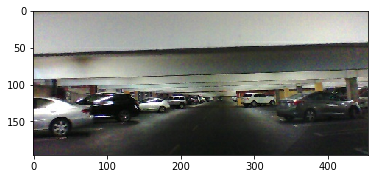

In [159]:
# Check loading was successful
import matplotlib.pyplot as plt
for xb, yb in train_dataset.batch(32):
    plt.imshow(xb[0].numpy())
    print('Corresponding label is: ', yb[0])
    break

In [160]:
# Load the test data
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [161]:
# Also preprocess the test data
test_dataset = test_dataset.map(preprocess_row)

### Step 3: Add some image augmentation with random brightness

In [162]:
def modify_brightness(image, target):
    # Note how target is unmodified
    return tf.image.random_brightness(image, 0.05), target

In [163]:
# Add our data augmentation procedure to the image pipeline
train_dataset = train_dataset.map(modify_brightness)

### Step 4: Define our convolutional architecture

In [164]:
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [165]:
# The model starts from here
input_shape = (196, 455, 3)
model = Sequential()
model.add(Input(input_shape))

In [166]:
# Utility function to add convolutional + batch normalization layers
def add_conv_module(model, filters):
    # Note the addition of L2 regularization
    model.add(Conv2D(filters, (5, 5), padding='valid', kernel_regularizer = l2(0.001), activation='relu', strides=(2, 2)))
    model.add(BatchNormalization())

In [167]:
# Add a bunch of batch normalization layers
add_conv_module(model, 24)
add_conv_module(model, 36)
add_conv_module(model, 48)
add_conv_module(model, 48)
add_conv_module(model, 48)

In [168]:
# Add the final classification layers
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))

In [170]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 96, 226, 24)       1824      
_________________________________________________________________
batch_normalization_v2_13 (B (None, 96, 226, 24)       96        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 111, 36)       21636     
_________________________________________________________________
batch_normalization_v2_14 (B (None, 46, 111, 36)       144       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 54, 48)        43248     
_________________________________________________________________
batch_normalization_v2_15 (B (None, 21, 54, 48)        192       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 9, 25, 48)        

In [183]:
# Test the model
model(xb[0:1])

<tf.Tensor: id=13619, shape=(1, 1), dtype=float32, numpy=array([[0.03127777]], dtype=float32)>

In [182]:
# Training mode (output will be different every time)
model(xb[0:1], training=True)

<tf.Tensor: id=13528, shape=(1, 1), dtype=float32, numpy=array([[0.79847306]], dtype=float32)>

### Step 5: Finally train

In [184]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mean_squared_error
model.compile(optimizer=RMSprop(0.001), loss=mean_squared_error)

In [185]:
import numpy as np
batch_size = 16
train_steps = np.ceil(len(train_images)/batch_size)
test_steps = np.ceil(len(test_images)/batch_size)

In [186]:
history = model.fit(train_dataset.shuffle(1000).batch(batch_size).repeat(), epochs=1, steps_per_epoch=train_steps,
          validation_data=test_dataset.batch(batch_size).repeat(),
          validation_steps=test_steps)

1875/1875 [==============================] - 1196s 638ms/step - loss: 0.7597 - val_loss: 0.9341


### Step 6: Make everything faster with tf.function

Autograph is a specialized tool that can speed-up your TensorFlow code by compiling it to a heavily-optimized low-level representation: https://www.tensorflow.org/alpha/guide/autograph

In [191]:
# We simply decorate a function where we call our trained model
@tf.function
def fast_predict(model, xb):
  return model(xb)

In [194]:
%timeit -r 3 -n 15 model(xb)

133 ms ± 3.07 ms per loop (mean ± std. dev. of 3 runs, 15 loops each)


In [195]:
%timeit -r 3 -n 15 fast_predict(model, xb)

77.5 ms ± 940 µs per loop (mean ± std. dev. of 3 runs, 15 loops each)
